In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
import math
from tqdm import tqdm

In [2]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([    transforms.ToTensor(), transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])
])


In [3]:
# loading the train data
batch_size = 100
#drop_last=True
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True )
# You should define x_train and y_train

Files already downloaded and verified
Files already downloaded and verified


### Dense (fully connected) layer

In [4]:
class Dense:
    def __init__(self,n_inputs,n_neurons):
        # He Weight Initialization
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2. / n_inputs)
        self.biases = np.zeros((1, n_neurons))
    
    def forward(self,inputs):
        self.inputs = inputs
        return np.dot(self.inputs, self.weights) + self.biases

    def backward(self,output_error):
        # calculating errors
        self.inputs_error = np.dot(output_error, self.weights.T)
        self.weights_grad = np.dot(self.inputs.T, output_error)
        self.biases_grad = np.sum(output_error.copy(), axis = 0,keepdims=True)
        return self.inputs_error

In [5]:

w = np.random.randn(10, 10) * np.sqrt(2 / 10)
b = np.zeros((1, 10))
print(w.shape)
print(b.shape)
print(b)

(10, 10)
(1, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Activation Layers


In [6]:
class ReLU:
    def forward(self,inputs):
        self.inputs = inputs.copy()
        return np.maximum(0,self.inputs)

    def backward(self, output_error):
        self.inputs_error = output_error.copy()
        self.inputs_error[self.inputs <= 0] = 0
        return self.inputs_error
        

In [7]:
class Sigmoid:
    def forward(self,inputs):
        self.outputs = 1 / (1 + np.exp(-inputs))
        return self.outputs

    def backward(self,output_error):
        self.outputs_grad = output_error * (1-self.outputs) * self.outputs 
        return self.outputs_grad

In [8]:
class Softmax:
    def forward(self, inputs):
        self.inputs = inputs.copy()
        exp_inputs = np.exp(self.inputs - np.max(self.inputs,axis = 1, keepdims= True))
        self.outputs = exp_inputs / np.sum(exp_inputs, axis=1, keepdims=True)
        return self.outputs


### Loss function

In [9]:
class Categorical_Cross_Entropy_loss:
    
    def forward(self, softmax_output, class_label):
        # Apply softmax function to the output
        self.softmax_output = np.clip(softmax_output, 1e-12, 1. - 1e-12)
        N = self.softmax_output.shape[0]
        # Convert the class label to one-hot encoding
        self.class_label = np.zeros_like(softmax_output)
        self.class_label[np.arange(N), class_label] = 1
        # Calculate the cross-entropy loss
        self.loss = -np.sum(self.class_label * np.log(self.softmax_output)) / N
        return self.loss
    
    def backward(self, class_label):
        # Calculate the derivative of the loss with respect to the softmax output
        N = self.softmax_output.shape[0]
        self.d_inputs = self.softmax_output.copy()
        #print(f"loss: {self.d_inputs.shape}, {samples}")
        #print(f"{class_label}")
        self.d_inputs[np.arange(N), class_label] -= 1
        self.d_inputs = self.d_inputs / N
        return self.d_inputs


### Optimizer

In [11]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.01):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

In [12]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate=learning_rate
        self.scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=learning_rate)
    def __call__(self, layer, num_epoch):
        # Update layer parameters based on gradient descent rule
        layer.weights = layer.weights - self.scheduler(num_epoch) * layer.weights_grad
        layer.biases  = layer.biases - self.scheduler(num_epoch) * layer.biases_grad

### Architecture

In [13]:
feature_extractor = resnet34(pretrained=True)
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
    param.requires_grad = False

feature_extractor.fc = nn.Identity() 

C:\Users\rrast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rrast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
#model
Layer1 = Dense(num_features,20)
Act1 = ReLU()
Layer2 = Dense(20,10)
Act2 = Softmax()
Loss = Categorical_Cross_Entropy_loss()
Optimizer = SGD()

### Train

In [15]:


epochs = 20

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", colour="blue"):
        # Forward pass
        x = feature_extractor(x_train)
        x = Layer1.forward(x)
        x = Act1.forward(x)
        x = Layer2.forward(x)
        x = Act2.forward(x)
        loss = Loss.forward(x, y_train.numpy())

        # Report batch metrics
        y_predict = np.argmax(x, axis=1)
        accuracy = np.mean(y_train.numpy() == y_predict)
        epoch_loss += loss
        epoch_accuracy += accuracy

        # Backward pass
        x = Loss.backward(y_train.numpy())
        #x = Act2.backward(x)
        x = Layer2.backward(x)
        x = Act1.backward(x)
        x = Layer1.backward(x)

        # Update parameters
        Optimizer(Layer1, epoch)
        Optimizer(Layer2, epoch)

    # Report epoch metrics
    epoch_loss /= len(train_dataloader)
    epoch_accuracy /= len(train_dataloader)
    print(f'Epoch: {epoch+1}')
    print(f'Loss: {epoch_loss:.7f}')
    print(f'Accuracy: {epoch_accuracy:.7f}')
    print('--------------------------')


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:23<00:00,  6.01it/s]


Epoch: 1
Loss: 2.2050082
Accuracy: 0.1962000
--------------------------


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:22<00:00,  6.08it/s]


Epoch: 2
Loss: 1.8992686
Accuracy: 0.3171200
--------------------------


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:22<00:00,  6.08it/s]


Epoch: 3
Loss: 1.7408366
Accuracy: 0.3755600
--------------------------


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:20<00:00,  6.20it/s]


Epoch: 4
Loss: 1.6713167
Accuracy: 0.4030600
--------------------------


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:25<00:00,  5.87it/s]


Epoch: 5
Loss: 1.6270627
Accuracy: 0.4207000
--------------------------


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:21<00:00,  6.14it/s]


Epoch: 6
Loss: 1.5951494
Accuracy: 0.4299400
--------------------------


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:25<00:00,  5.82it/s]


Epoch: 7
Loss: 1.5796949
Accuracy: 0.4374800
--------------------------


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:22<00:00,  6.09it/s]


Epoch: 8
Loss: 1.5616788
Accuracy: 0.4442800
--------------------------


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:20<00:00,  6.24it/s]


Epoch: 9
Loss: 1.5496180
Accuracy: 0.4509200
--------------------------


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:19<00:00,  6.27it/s]


Epoch: 10
Loss: 1.5342017
Accuracy: 0.4567000
--------------------------


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:21<00:00,  6.10it/s]


Epoch: 11
Loss: 1.5290539
Accuracy: 0.4577000
--------------------------


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:21<00:00,  6.10it/s]


Epoch: 12
Loss: 1.5209522
Accuracy: 0.4630800
--------------------------


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:20<00:00,  6.24it/s]


Epoch: 13
Loss: 1.5123285
Accuracy: 0.4654800
--------------------------


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:22<00:00,  6.05it/s]


Epoch: 14
Loss: 1.5082025
Accuracy: 0.4675200
--------------------------


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:26<00:00,  5.77it/s]


Epoch: 15
Loss: 1.5032042
Accuracy: 0.4674600
--------------------------


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:26<00:00,  5.81it/s]


Epoch: 16
Loss: 1.4943608
Accuracy: 0.4718000
--------------------------


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.67it/s]


Epoch: 17
Loss: 1.4921582
Accuracy: 0.4724800
--------------------------


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.50it/s]


Epoch: 18
Loss: 1.4951982
Accuracy: 0.4746800
--------------------------


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.61it/s]


Epoch: 19
Loss: 1.4885723
Accuracy: 0.4755800
--------------------------


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [01:26<00:00,  5.75it/s]

Epoch: 20
Loss: 1.4810946
Accuracy: 0.4762800
--------------------------


### Evaluation

NameError: name 'seaborn' is not defined

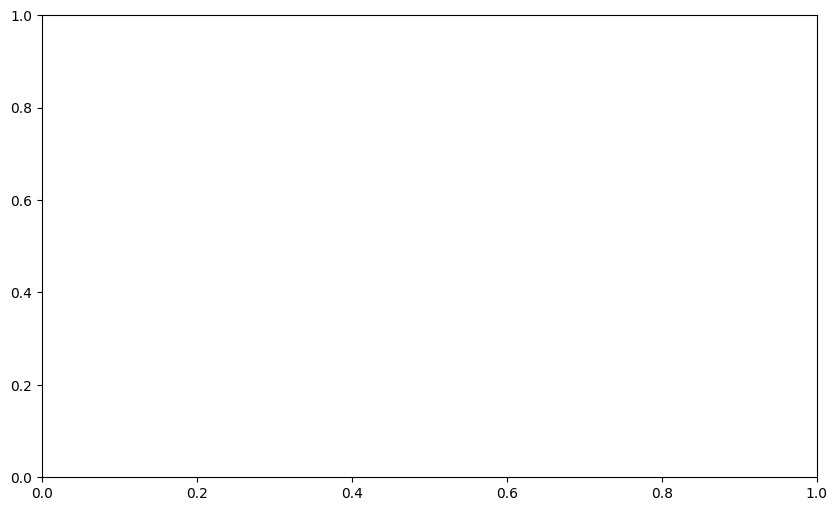

In [17]:
#Confusion Matrix for the training set
cm_train = confusion_matrix(y_train, y_predict)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the training set")
plt.show()

#Confusion Matrix for the test set
# // To Do